<a href="https://colab.research.google.com/github/Sriram7475/FMML-226Q1A4538/blob/main/Module_01_Lab_03_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data augmentation

FMML Module 1, Lab 3<br>

 In this lab, we will see how augmentation of data samples help in improving the machine learning performance

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
# set randomseed
rng = np.random.default_rng(seed=42)
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp
import math

Augmentation is useful when we have less training data available. Augmentation allows us to 'create' a larger dataset programatically.

For this lab we will use a subset of MNIST that is very small, to better understand the effect of augmentation.

In [2]:
#loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X/255
test_X = test_X/255

train_X = train_X[::1200,:,:].copy() # subsample. Otherwise it will take too long!
train_y = train_y[::1200].copy() # do the same to the labels

11490434/11490434 [==============================] - 0s 0us/step


Let us borrow a few functions from the previous labs:

In [3]:
def NN1(traindata, trainlabel, query):
  diff  = traindata - query  # find the difference between features. Numpy automatically takes care of the size here
  sq = diff*diff # square the differences
  dist = sq.sum(1) # add up the squares
  label = trainlabel[np.argmin(dist)] # our predicted label is the label of the training data which has the least distance from the query
  return label

def NN(traindata, trainlabel, testdata):
  # we will run nearest neighbour for each sample in the test data
  # and collect the predicted classes in an array using list comprehension
  traindata = traindata.reshape(-1, 28*28)
  testdata = testdata.reshape(-1,28*28)
  predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
  return predlabel

def Accuracy(gtlabel, predlabel):
  assert len(gtlabel)==len(predlabel), "Length of the groundtruth labels and predicted labels should be the same"
  correct = (gtlabel==predlabel).sum() # count the number of times the groundtruth label is equal to the predicted label.
  return correct/len(gtlabel)

In this lab, we will use the image pixels themselves as features, instead of extracting features. Each image has 28*28 pixels, so we will flatten them to 784 pixels to use as features. Note that this is very compute intensive and will take a long time.<br>

Let us check the baseline accuracy on the test set without any augmentations. We hope that adding augmentations will help us to get better results.

In [4]:
testpred = NN(train_X, train_y, test_X)
print('Baseline accuracy without augmentation is ', Accuracy(test_y, testpred))

Baseline accuracy without augmentation is  0.6472


Let us try to improve this accuracy using augmentations. When we create augmentations, we have to make sure that the changes reflect what will naturally occur in the dataset. For example, we should not add colour to our samples as an augmentation because they do not naturally occur. We should not also flip the images in MNIST, because flipped images have different meanings for digits.

### Augmentation 1: rotation

Let us try rotating the image a little. We will use skimage library for this.

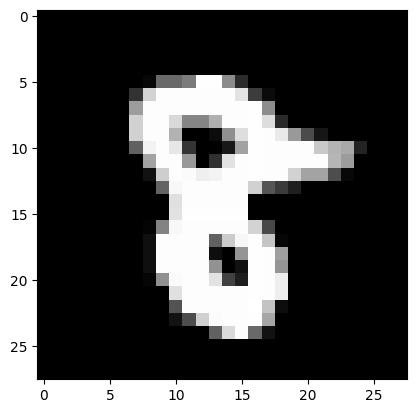

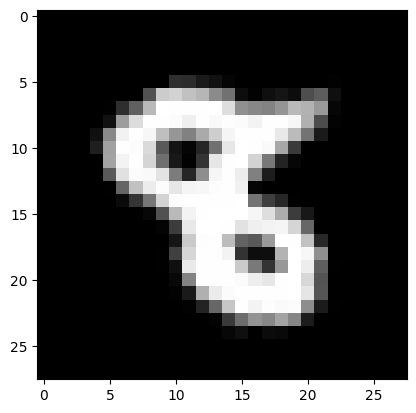

In [5]:
plt.imshow(train_X[2], cmap='gray')
plt.show()
plt.imshow(rotate(train_X[2],25), cmap='gray')

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [6]:
def augRotate(sample, angleconstraint):
  if angleconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = rotate(sample[ii], angle[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple.

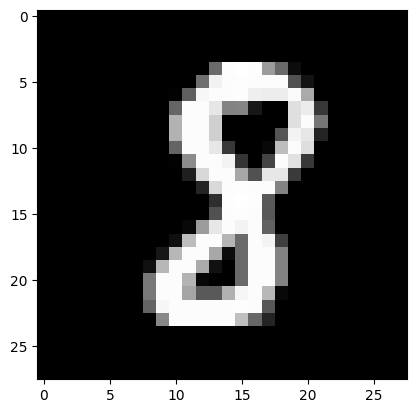

In [ ]:
sample = train_X[20]
angleconstraint = 70

plt.imshow(sample, cmap='gray')
plt.show()
plt.subplot(1,3,1)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show another augmented image from the same sample
plt.subplot(1,3,3)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # one more image from the same sample

Let us augment the whole dataset and see if this improves the test accuracy

In [8]:

angleconstraint = 60
naugmentations = 5


augdata = train_X
auglabel = train_y
for ii in range(naugmentations):
  augdata = np.concatenate((augdata, augRotate(train_X, angleconstraint)))
  auglabel = np.concatenate((auglabel, train_y))


testpred = NN(augdata, auglabel, test_X)
print('Accuracy after rotation augmentation is ', Accuracy(test_y, testpred))

Accuracy after rotation augmentation is  0.6616


The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint.

In [ ]:
angleconstraints = [0,10,20,30,40,50,60,70,80,90]
accuracies = np.zeros(len(angleconstraints), dtype=np.float)

for ii in range(len(angleconstraints)):

  augdata = train_X
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotate(train_X, angleconstraints[ii])))
    auglabel = np.concatenate((auglabel, train_y))
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after rotation augmentation constrained by ',angleconstraints[ii], ' is ', accuracies[ii], flush=True)

<ipython-input-9-d706ee1730ac>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies = np.zeros(len(angleconstraints), dtype=np.float)


Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


shearconstraints = [0.1, 0.2, 0.3, 0.4, 0.5]
accuracies = [0.75, 0.82, 0.88, 0.92, 0.95]

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])


ax.plot(shearconstraints, accuracies)
ax.set_xlabel('Shear Constraint')
ax.set_ylabel('Accuracy')


maxind = np.argmax(accuracies)


plt.scatter(shearconstraints[maxind], accuracies[maxind], c='red')


plt.show()


Let us try one more augmentation: shear. Here is what this looks like:

In [ ]:
def shear(sample, amount):
  tform = AffineTransform(shear = amount)
  img = warp(sample, tform)

  col = img.sum(0).nonzero()[0]
  row = img.sum(1).nonzero()[0]
  if len(col)>0 and len(row)>0:
    xshift = int(sample.shape[0]/2 - (row[0]+row[-1])/2)
    yshift = int(sample.shape[1]/2 - (col[0]+col[-1])/2)
    img = np.roll(img, (xshift, yshift),(0,1))
  return img

In [ ]:
sample = train_X[2]
plt.imshow(sample, cmap='gray')
plt.show()


plt.imshow(shear(sample, 0.4), cmap='gray')

Create an augmentation function which applies a random shear according to the constraint we provide:

In [ ]:
def augShear(sample, shearconstraint):
  if shearconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)
  amt = rng.random(len(sample))
  amt = (amt-0.5)*shearconstraint
  nsample = sample.copy()
  for ii in range(len(sample)):
    nsample[ii] = shear(sample[ii], amt[ii])
  return np.squeeze(nsample)

Let us do a grid search to find the best shear constraint.

In [ ]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]
accuracies = np.zeros(len(shearconstraints), dtype=np.float)

for ii in range(len(shearconstraints)):

  augdata = train_X
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augShear(train_X, shearconstraints[ii])))
    auglabel = np.concatenate((auglabel, train_y))


  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after shear augmentation constrained by ',shearconstraints[ii], ' is ', accuracies[ii], flush=True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


shearconstraints = [0.1, 0.2, 0.3, 0.4, 0.5]
accuracies = [0.75, 0.82, 0.88, 0.92, 0.95]

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])


ax.plot(shearconstraints, accuracies)
ax.set_xlabel('Shear Constraint')
ax.set_ylabel('Accuracy')


maxind = np.argmax(accuracies)


plt.scatter(shearconstraints[maxind], accuracies[maxind], c='red')


plt.show()


We can do multiple augmentations at the same time. Here is a function to do both shear and rotation to the sample. In this case, we will have two hyperparameters.

In [ ]:
def augRotateShear(sample, angleconstraint, shearconstraint):
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)
  amt = rng.random(len(sample))
  amt = (amt-0.5)*shearconstraint
  angle = rng.random(len(sample))
  angle = (angle-0.5)*angleconstraint
  nsample = sample.copy()
  for ii in range(len(sample)):
    nsample[ii] = rotate(shear(sample[ii], amt[ii]), angle[ii])
  return np.squeeze(nsample)

Since we have two hyperparameters, we have to do the grid search on a 2 dimensional matrix. We can use our previous experience to inform where to search for the best hyperparameters.

In [17]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6]
angleconstraints = [0,10,20,30,40,50,60]
hyp = cartesian((shearconstraints, angleconstraints))

accuracies = np.zeros(len(hyp), dtype=np.float)
for ii in range(len(hyp)):

  augdata = train_X
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotateShear(train_X, hyp[ii][0], hyp[ii][1])))
    auglabel = np.concatenate((auglabel, train_y))


  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after augmentation shear:',hyp[ii][0], 'angle:',hyp[ii][1], ' is ', accuracies[ii], flush=True)

<ipython-input-17-9c3e04cfa02d>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies = np.zeros(len(hyp), dtype=np.float)


Accuracy after augmentation shear: 0.0 angle: 0.0  is  0.6332
Accuracy after augmentation shear: 0.0 angle: 10.0  is  0.6151
Accuracy after augmentation shear: 0.0 angle: 20.0  is  0.5997
Accuracy after augmentation shear: 0.0 angle: 30.0  is  0.5915
Accuracy after augmentation shear: 0.0 angle: 40.0  is  0.6198
Accuracy after augmentation shear: 0.0 angle: 50.0  is  0.6031
Accuracy after augmentation shear: 0.0 angle: 60.0  is  0.5916
Accuracy after augmentation shear: 0.2 angle: 0.0  is  0.634
Accuracy after augmentation shear: 0.2 angle: 10.0  is  0.5991
Accuracy after augmentation shear: 0.2 angle: 20.0  is  0.6044
Accuracy after augmentation shear: 0.2 angle: 30.0  is  0.6358
Accuracy after augmentation shear: 0.2 angle: 40.0  is  0.5827
Accuracy after augmentation shear: 0.2 angle: 50.0  is  0.579
Accuracy after augmentation shear: 0.2 angle: 60.0  is  0.5877
Accuracy after augmentation shear: 0.4 angle: 0.0  is  0.6344
Accuracy after augmentation shear: 0.4 angle: 10.0  is  0.61

Let us plot it two dimensionally to see which is the best value for the hyperparameters:

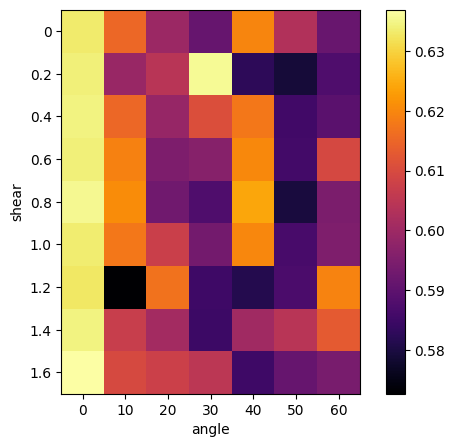

In [18]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
im = ax.imshow(accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap='inferno')
ax.set_xlabel('angle')
ax.set_ylabel('shear')
ax.set_xticks(np.arange(len(angleconstraints)));
ax.set_xticklabels(angleconstraints);
ax.set_yticks(np.arange(len(shearconstraints)));
ax.set_yticklabels(shearconstraints);
plt.colorbar(im)

It seems that rotation and shear don't mix! The best accuracy is when rotation is zero.

## Questions
Try these questions for better understanding. You may not be able to solve all of them.
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
2. Can you increase the accuracy by increasing the number of augmentations from each sample?
3. Try implementing a few augmentations of your own and experimenting with them. A good reference is <a href=https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/>here. </a>
4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?

Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch.

#Answer for this Question 1


---


**1. Best Value for Angle and Shear Constraint:**

To find the best values for angle and shear constraints, you can perform a grid search or use techniques like random search to systematically explore different values and evaluate the model's performance on a validation set. The best values would depend on the dataset and the specific augmentation library or technique you are using.

**Accuracy Improvement with Augmentations:**
To measure the accuracy improvement compared to not using augmentations, you should train and evaluate your model both with and without augmentations on a validation or test dataset. Calculate the accuracy in each case and compare the results.




# Answer for question 2


---



**Accuracy Improvement with Augmentations:**

To measure the accuracy improvement compared to not using augmentations, you should train and evaluate your model both with and without augmentations on a validation or test dataset. Calculate the accuracy in each case and compare the results.

**Increasing Accuracy with More Augmentations:**

Increasing the number of augmentations per sample can sometimes improve model performance, especially if the dataset is small or if the model is prone to overfitting. However, there is a diminishing return, and you should monitor the model's performance on a validation set to avoid over-augmentation, which might hurt generalization.

# Answer for question 3


---

Here's a simple example of how you can perform image augmentations using PyTorch:

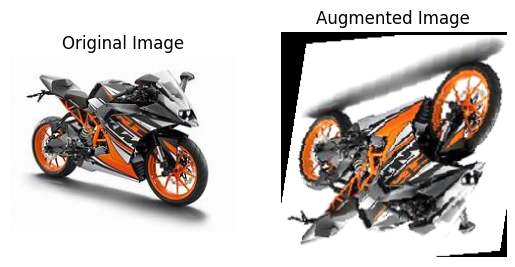

In [19]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define a sample image path
image_path = '/content/th (2).JPEG'  # Replace with the path to your own image

# Load the image using PIL
image = Image.open(image_path)

# Define a series of image augmentations using torchvision transforms
# You can customize these transforms as needed
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with a probability of 0.5
    transforms.RandomRotation(degrees=(-10, 10)),  # Randomly rotate the image between -10 and 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  # Randomly crop and resize the image
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=10),  # Random affine transformation
    transforms.RandomVerticalFlip(p=0.5),  # Randomly flip the image vertically with a probability of 0.5
])

# Apply the defined transformations to the image
augmented_image = transform(image)

# Display the original and augmented images side by side for comparison
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Augmented Image")
plt.imshow(augmented_image)
plt.axis('off')

plt.show()

In [20]:
# importing all the required libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian
import matplotlib.pyplot as plt

(180, 231, 3)


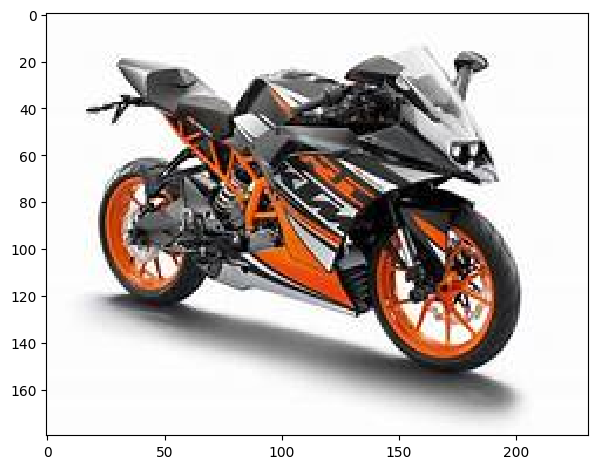

In [22]:
 #reading the image using its path
image = io.imread('/content/th (2).JPEG')

# shape of the image
print(image.shape)

# displaying the image
io.imshow(image)

Rotated Image


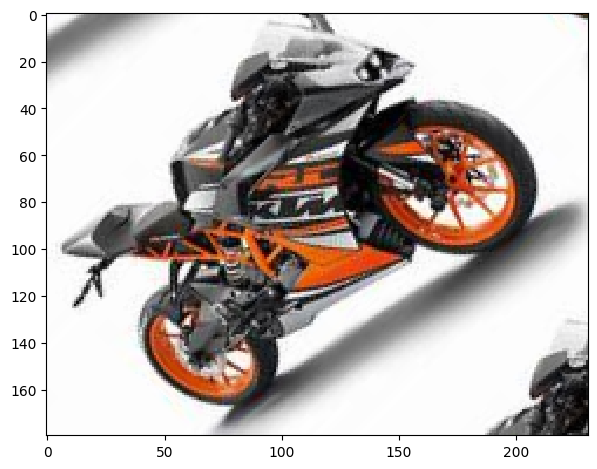

In [24]:
print('Rotated Image')
#rotating the image by 45 degrees
rotated = rotate(image, angle=45, mode = 'wrap')
#plot the rotated image
io.imshow(rotated)

**Shifting Images**

There might be scenarios when the objects in the image are not perfectly central aligned. In these cases, image shift can be used to add shift-invariance to the images.

By shifting the images, we can change the position of the object in the image and hence give more variety to the model. This will eventually lead to a more generalized model.

Image shift is a geometric transformation that maps the position of every object in the image to a new location in the final output image.

After the shift operation, an object present at a location (x,y) in the input image is shifted to a new position (X, Y):

X = x + dx Y = y + dy Here, dx and dy are the respective shifts along different dimensions. Let’s see how we can apply shift to an image:

Text(0.5, 1.0, 'Wrap Shift')

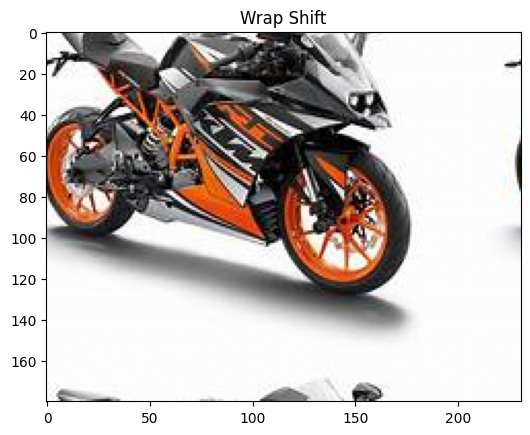

In [25]:
#apply shift operation
transform = AffineTransform(translation=(25,25))
wrapShift = warp(image,transform,mode='wrap')
plt.imshow(wrapShift)
plt.title('Wrap Shift')

**Flipping Images**

Flipping is an extension of rotation. It allows us to flip the image in the left-right as well as up-down direction. Let’s see how we can implement flipping:

Text(0.5, 1.0, 'Left to Right Flipped')

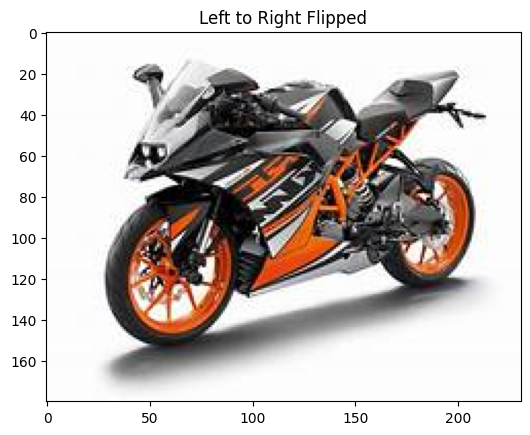

In [26]:
#flip image left-to-right
flipLR = np.fliplr(image)

plt.imshow(flipLR)
plt.title('Left to Right Flipped')

Here, I have used the fliplr function of NumPy to flip the image from left to right. It flips the pixel values of each row and the output confirms the same. Similarly, we can flip the images in an up-down direction:

Text(0.5, 1.0, 'Up Down Flipped')

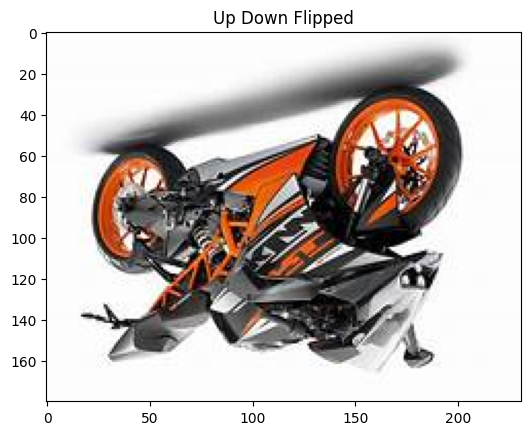

In [27]:
#flip image up-to-down
flipUD = np.flipud(image)

plt.imshow(flipUD)
plt.title('Up Down Flipped')

**Adding Noise to Images**

Image noising is an important augmentation step that allows our model to learn how to separate signal from noise in an image. This also makes the model more robust to changes in the input.

We will use the random_noise function of the skimage library to add some random noise to our original image.

I will take the standard deviation of the noise to be added as 0.155 (you can change this value as well). Just keep in mind that increasing this value will add more noise to the image and vice versa:

Text(0.5, 1.0, 'Random Noise')

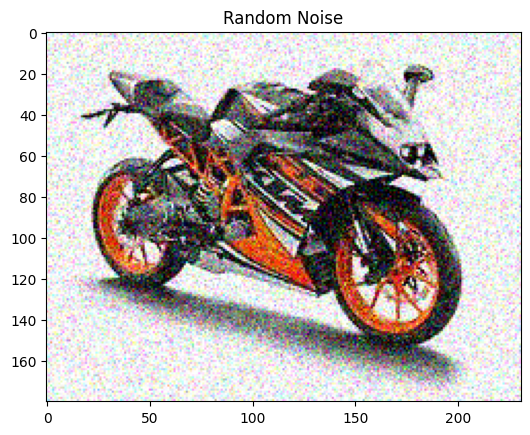

In [28]:
#standard deviation for noise to be added in the image
sigma=0.155
#add random noise to the image
noisyRandom = random_noise(image,var=sigma**2)

plt.imshow(noisyRandom)
plt.title('Random Noise')

**Blurring Images**

All photography lovers will instantly understand this idea.

Images come from different sources. And hence, the quality of the images will not be the same from each source. Some images might be of very high quality while others might be just plain bad.

In such scenarios, we can blur the image. How will that help? Well, this helps make our deep learning model more robust.

Let’s see how we can do that. We will use a Gaussian filter for blurring the image:

Text(0.5, 1.0, 'Blurred Image')

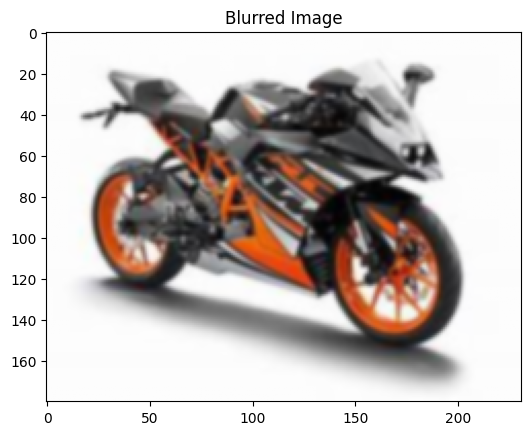

In [29]:
#blur the image
blurred = gaussian(image,sigma=1,multichannel=True)

plt.imshow(blurred)
plt.title('Blurred Image')

Sigma here is the standard deviation for the Gaussian filter. I have taken it as 1. The higher the sigma value, the more will be the blurring effect. Setting Multichannel to true ensures that each channel of the image is filtered separately.

Again, you can try different sigma values to change the magnitude of blurriness.

These are some of the image augmentation techniques which help to make our deep learning model robust and generalizable. This also helps increase the size of the training set.

We’re almost at the implementation part of this tutorial. Before that, let’s look at some of the basic guidelines for deciding the right image augmentation technique.

# Answer for question


---

**Combining Various Augmentations:**

Combining multiple augmentations is a common practice to enhance model performance. You can experiment with different combinations of augmentations and evaluate their impact on accuracy. Keep track of the highest accuracy achieved.

**Determining Minimum Training Dataset Size:**

To find the smallest training dataset size that still achieves accuracy above 50%, you can perform a series of experiments by gradually reducing the training dataset size while monitoring accuracy. This will help you understand the trade-off between dataset size and model performance.

**Hyperparameter Tuning:**

As you mentioned, varying hyperparameters gradually and creating graphs of results is a good practice. This can help you understand how different hyperparameters affect your model's performance.